In [1]:
import pandas as pd
import numpy as np

from glob import glob
import os
import sys
import cv2
from PIL import Image

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Path 지정
class cfg:
    data_dir = '../input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [3]:
#Mask Class 지정
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

In [4]:
#train 정보 불러오기
df = pd.read_csv(cfg.df_path)

#확인
df.sample(10)


,id,gender,race,age,path
949,001739,male,Asian,29,001739_male_Asian_29
1160,003112,female,Asian,20,003112_female_Asian_20
1769,004215,female,Asian,60,004215_female_Asian_60
60,000216,female,Asian,56,000216_female_Asian_56
735,001470,male,Asian,59,001470_male_Asian_59
498,001129,male,Asian,20,001129_male_Asian_20
1093,003028,female,Asian,20,003028_female_Asian_20
2521,006511,male,Asian,19,006511_male_Asian_19
629,001302,female,Asian,20,001302_female_Asian_20
2596,006648,female,Asian,19,006648_female_Asian_19


### 사전 정보
- 현재 `train data` 구성
    1. 2700명의 아시아 계열 사람들로 구성 
    2. 각 사람당 1장의 `Incorrect`, 5장의 `Mask`, 1장의 `Not wear` 사진으로 구성
    3. 이미지 Size : (384, 512)
    4. 우리가 예측해야 되는 클래스는 1~18의 클래스로 각 클래스는 `Mask여부`, `나이`, `성별`이 합쳐진 것 
        - 각 클래스별 세부내용 : 
            - 1. `Mask 여부` -  `Mask` : 0, `Incorrect` : 1, `Normal(Not wear)` : 2
            - 2. `나이` - `Young(<30)` : 0, `Middle(30<= and < 60)` : 1, `Old(>=60)` : 2
            - 3. `성별` - `Male` : 0, `Female` : 1



# EDA를 통해서 확인해볼 것 

1. `train data`의 클래스별 분포
    - **확인할 분포들** : 
        - (1) `Mask여부` , `나이`, `성별` 별 Class 분포
        - (2) `나이`별 `성별`분포 

    **key point 1.** : Class 사이의 분포를 파악하여 불균형 상태를 파악, 이를 통해서 train/val set을 구성할 때 적용할 방법, 어떤 Loss를 사용할지, Augmentation 방법에 무엇을 적용할지 선택 가능
    
2. `train data`의 결측치 또는 잘못 분류된 Class, 중복 데이터의 유무

    **key point 2.** : 결측치 처리, 라벨링, 전처리등에 활용 가능 

3. `Mask` 종류 (Incorrect, Mask1~5, Not wear)별 RGB, Grayscale 분포 관계 파악





# `train data` 클래스별 분포

### label 기준 : mask, gender, age
- 1. `Mask 여부` -  `Mask` : 0, `Incorrect` : 1, `Normal(Not wear)` : 2
- 2. `나이` - `Young(<30)` : 0, `Middle(30<= and < 60)` : 1, `Old(>=60)` : 2
- 3. `성별` - `Male` : 0, `Female` : 1


In [5]:
#Make New df - 현재 df는 사람정보만 나타남 -> 마스크 정보 추가

new_data = []


for idx, img_id in enumerate(df.path.values):
    age = df.age[idx]
    gender = df.gender[idx]

    for img in glob(os.path.join(cfg.img_dir, img_id, '*')):
        temp = [img_id, img, age, gender]

        #mask
        if 'incorrect_mask' in img:
            temp.append(1)
        elif 'normal' in img:
            temp.append(2)
        else:
            temp.append(0)

        #gender
        if gender == 'male':
            temp.append(0)
        else: 
            temp.append(1)
        
        #age
        if age < 30:
            temp.append(0)
        elif 30 <= age < 60:
            temp.append(1)
        else:
            temp.append(2)

        new_data.append(temp)

n_df = pd.DataFrame(data=new_data, columns=['img_id', 'path', 'age','gender', 'mask_label', 'gender_label', 'age_label'])

#확인
n_df
            

,img_id,path,age,gender,mask_label,gender_label,age_label
0,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1
1,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1
2,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1
3,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,1,1,1
4,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1
...,...,...,...,...,...,...,...
18895,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0
18896,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,1,0,0
18897,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0
18898,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0


## 전체 클래스의 분포는 어떨까?

In [6]:
n_df[['mask_label', 'gender_label', 'age_label']]

,mask_label,gender_label,age_label
0,0,1,1
1,0,1,1
2,0,1,1
3,1,1,1
4,0,1,1
...,...,...,...
18895,0,0,0
18896,1,0,0
18897,0,0,0
18898,0,0,0


In [7]:
total_label = []

for m, g, a in zip(n_df['mask_label'], n_df['gender_label'], n_df['age_label']):
    total = m * 6 + g * 3 + a # 변환 공식
    total_label.append(total)

In [8]:
n_df['total_label'] = total_label
n_df

,img_id,path,age,gender,mask_label,gender_label,age_label,total_label
0,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1,4
1,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1,4
2,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1,4
3,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,1,1,1,10
4,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1,4
...,...,...,...,...,...,...,...,...
18895,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0,0
18896,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,1,0,0,6
18897,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0,0
18898,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0,0


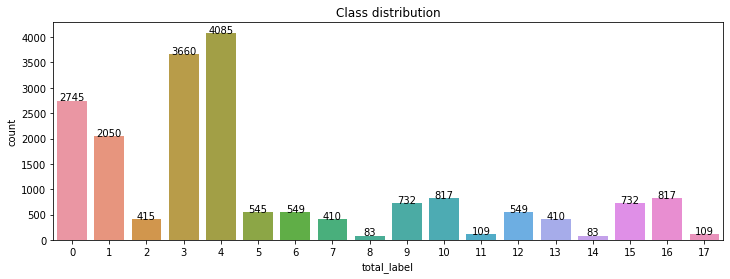

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(n_df, x='total_label', ax=ax)
for num in range(18):
    ax.text(x=num, y=len(n_df[n_df['total_label'] == num]), s=len(n_df[n_df['total_label'] == num]), ha='center')

ax.set_title('Class distribution')
plt.show()

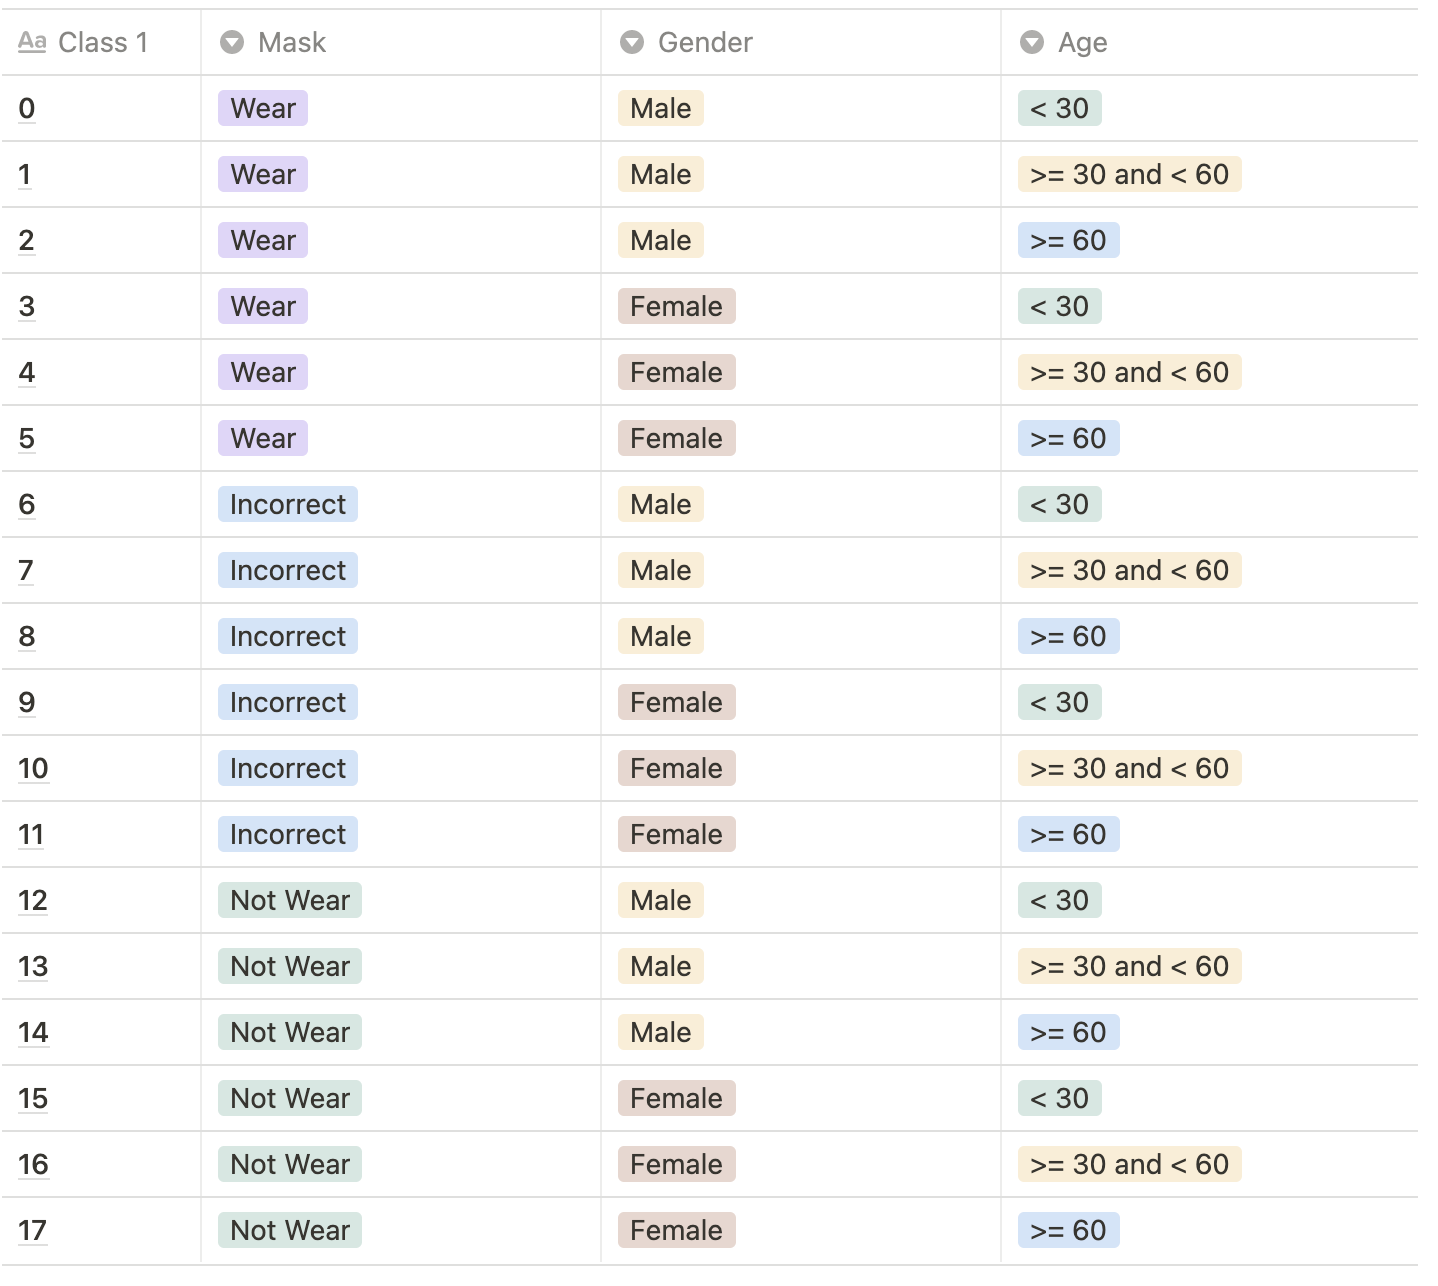

## Ch.1 `Mask여부` 분포

+) 결측 데이터 파악 : 2700* (1+5+1) =18900,  모든 `Mask여부` 분포를 합쳤을 때 같은지 확인

In [10]:
#분포 숫자로 표현
print(n_df['mask_label'].value_counts())
print('총합 :', sum(n_df['mask_label'].value_counts()))

0    13500
2     2700
1     2700
Name: mask_label, dtype: int64
총합 : 18900


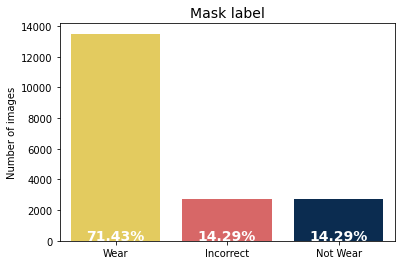

In [11]:
#시각화 
plt.figure(figsize=(6, 4)) 
ax = sns.countplot(x ='mask_label', data = n_df, palette=["#F9D949", "#EA5455", "#002B5B"])

plt.xticks( np.arange(3), ['Wear', 'Incorrect', 'Not Wear'] )
plt.title('Mask label',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = n_df['mask_label'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 40, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

plt.show()

###  1. `Mask` class가 다른 `Incorrect`, `Not waer`보다 5배 정도 많다 - 불균형적이다 

## Ch.2 `나이` 분포

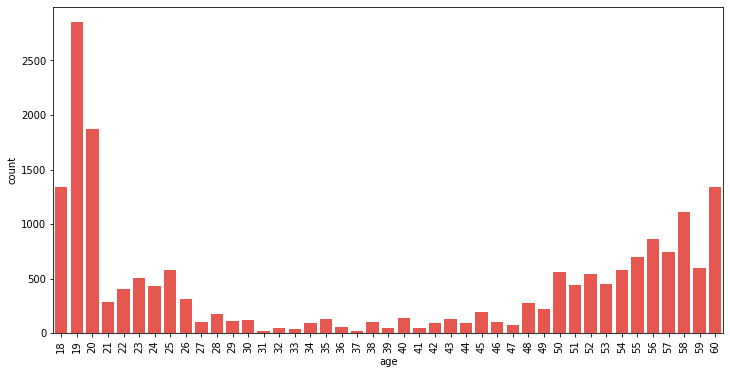

In [12]:
#연속형 나이
plt.figure(figsize=(12, 6))
sns.countplot(data=n_df, x='age', color='#ff4136')
plt.xticks(rotation=90)
plt.show()

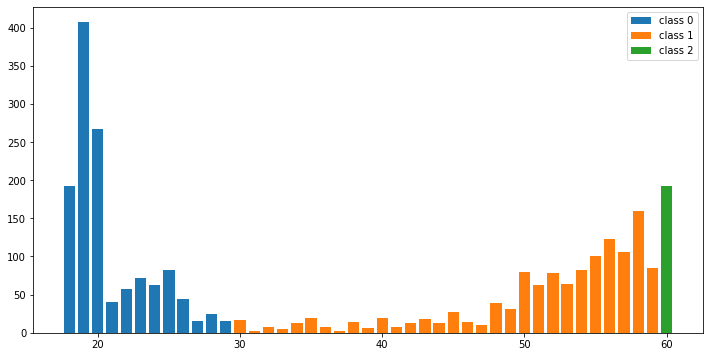

In [13]:
age_per_class = df['age'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(age_per_class.loc[:30].index, age_per_class.loc[:30], label='class 0')
plt.bar(age_per_class.loc[30:60].index, age_per_class.loc[30:60], label='class 1')
plt.bar(age_per_class.loc[60:].index, age_per_class.loc[60:], label='class 2')
plt.legend()
plt.show()

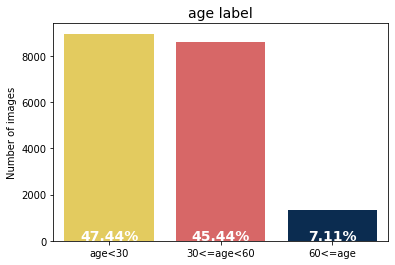

In [14]:
#범주형 나이 분포
plt.figure(figsize=(6, 4)) 
ax = sns.countplot(x ='age_label', data = n_df, palette=["#F9D949", "#EA5455", "#002B5B"])

plt.xticks( np.arange(3), ['age<30', '30<=age<60', '60<=age'] )
plt.title('age label',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = n_df['age_label'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 40, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

plt.show()

###  2. `60>=` class가 다른 Age label보다 약 8배 적다 - 불균형

In [15]:
df['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

In [16]:
def split_age(age):
    if age < 20:
        return 1
    elif age < 30:
        return 2
    elif age < 40:
        return 3
    elif age < 50:
        return 4
    elif age < 60:
        return 5
    else:
        return 6

In [17]:
splited_age = n_df['age'].apply(lambda x: split_age(x))
splited_age = splited_age.value_counts().sort_index().to_frame()
splited_age

,age
1,4193
2,4774
3,665
4,1344
5,6580
6,1344


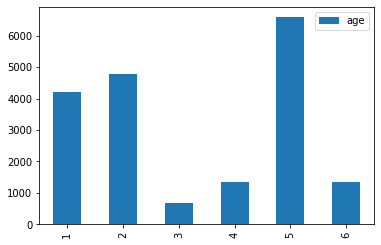

In [18]:
splited_age.plot.bar()

나이 분류가 어렵다는데.. 나이 클래스 경계가 명확할까?

In [19]:
def boundary_age(age):
    if  25 < age < 35:
        return 1
    elif 55 < age < 60:
        return 2

In [20]:
boundaried_age = n_df['age'].apply(lambda x: boundary_age(x))
boundaried_age = boundaried_age.value_counts().sort_index().to_frame()
boundaried_age

,age
1.0,1015
2.0,3311


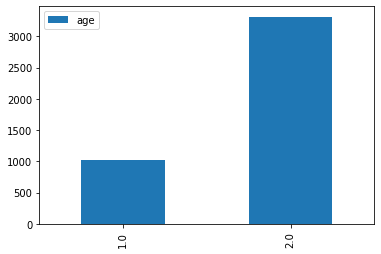

In [21]:
boundaried_age.plot.bar()

## Ch.3 `성별` 분포


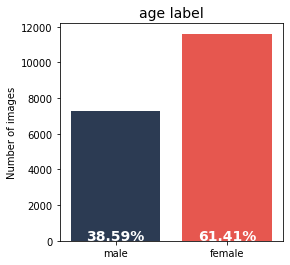

In [22]:
#성별 분포
plt.figure(figsize=(4, 4)) 
ax = sns.countplot(x ='gender_label', data = n_df, palette=["#263959", "#FF4136"])

plt.xticks( np.arange(2), ['male', 'female'] )
plt.title('age label',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = n_df['gender_label'].value_counts().sort_values()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 40, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')

plt.show()

###  3. `Female` 데이터가 `Male`보다 약 600백개 더 많다

## Ch. 4 나이별 성별 분포 

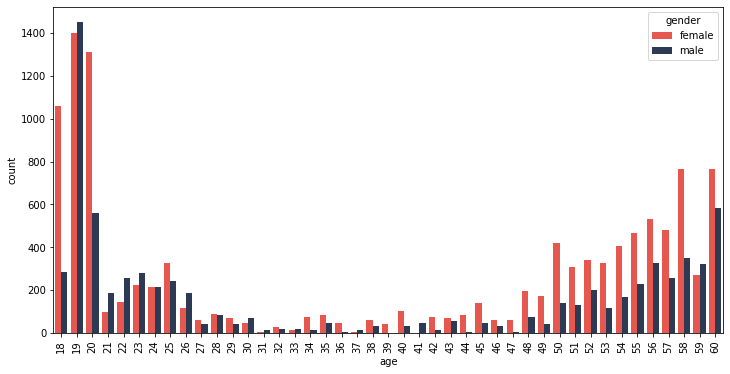

In [23]:
plt.figure(figsize=(12, 6))
sns.countplot(data=n_df, x='age', hue='gender', palette=["#FF4136", "#263959"])
plt.xticks(rotation=90)
plt.show()

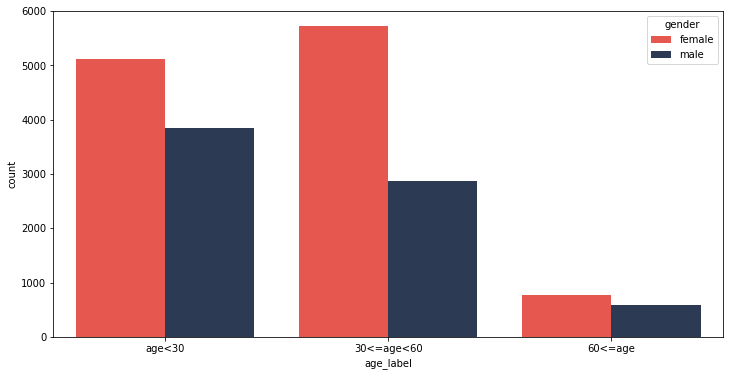

In [24]:
plt.figure(figsize=(12, 6))
sns.countplot(data=n_df, x='age_label', hue='gender', palette=["#FF4136", "#263959"])
plt.xticks( np.arange(3), ['age<30', '30<=age<60', '60<=age'] )
plt.show()

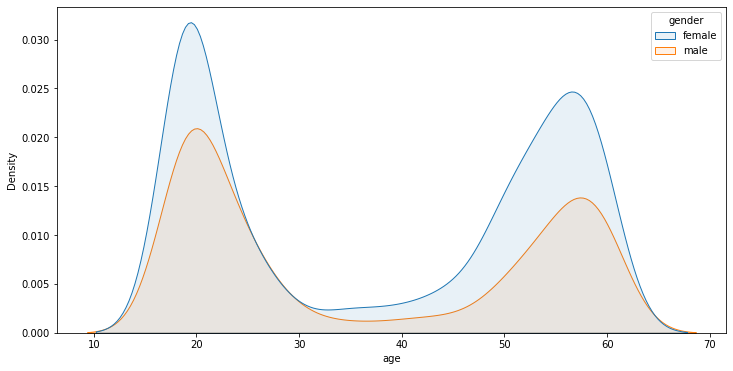

In [25]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot()
sns.kdeplot(data=n_df, x='age', hue='gender', fill=True, alpha=0.1, ax=ax)
plt.show()

## Ch. 5 결측치, 중복되는 데이터, 잘못 라벨링 된 데이터 파악하기

1. 일단 결측치는 없는 것으로 파악

In [26]:

def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

def plot_mask_images(img_dir, img_id):
    """
    마스크 정상착용 5장과 이상하게 착용한 1장을 2x3의 격자에 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    """
    ext = get_ext(img_dir, img_id)
    imgs = [np.array(Image.open(os.path.join(img_dir, img_id, class_name + ext))) for class_name in num2class[:-1]]
    
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(15, 12))
    for i in range(n_rows*n_cols):
        axes[i//(n_rows+1)][i%n_cols].imshow(imgs[i])
        axes[i//(n_rows+1)][i%n_cols].set_title(f'{num2class[i]}', color='r')
    plt.tight_layout()
    plt.show()

In [27]:
def plot_raw_images(img_dir, img_id):
    """
    마스크 미착용 이미지를 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    """
    ext = get_ext(img_dir, img_id)
    img = np.array(Image.open(os.path.join(img_dir, img_id, 'normal' + ext)))
    
    plt.figure(figsize=(6,6))
    plt.imshow(img)

def show_from_id(idx):
    img_id = df.iloc[idx].path
    gen = df.iloc[idx].gender
    age = df.iloc[idx].age
    plot_raw_images(cfg.img_dir, img_id)
    plt.title(f'{gen} {age}')
    plt.show()


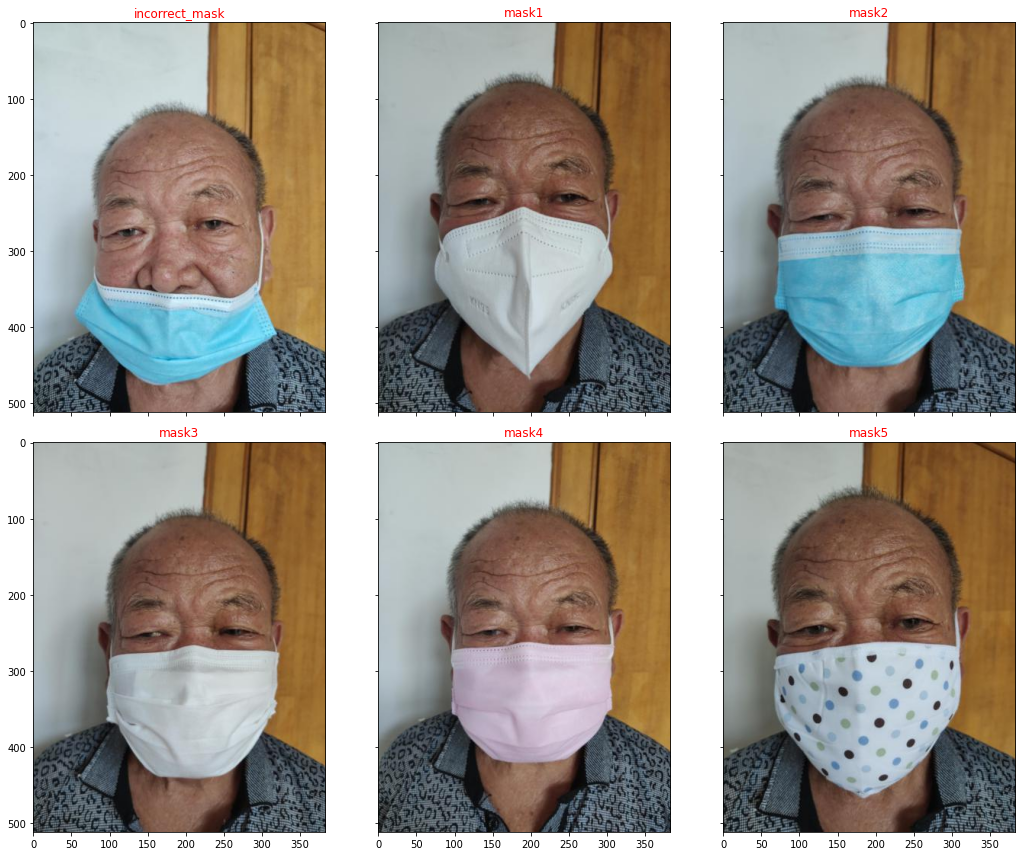

In [28]:
idx = 500
img_id = n_df.iloc[idx].img_id
plot_mask_images(cfg.img_dir, img_id)

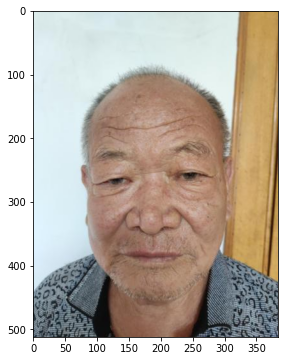

In [29]:
img_id = n_df.iloc[idx].img_id
plot_raw_images(cfg.img_dir, img_id)

2. 잘못된 레이블이 존재함

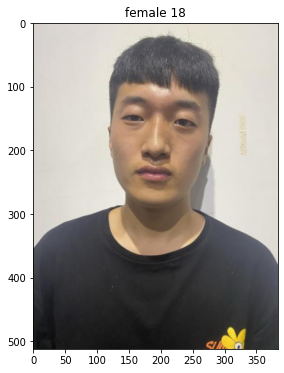

In [30]:
show_from_id(2399)

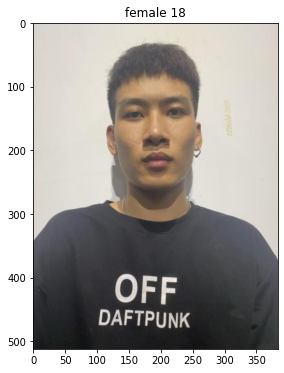

In [31]:
show_from_id(2400)

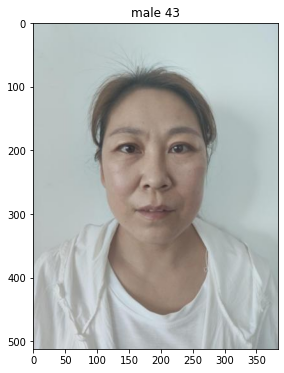

In [32]:
show_from_id(1912)

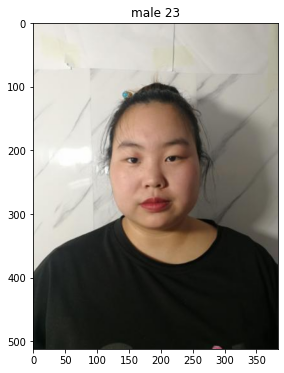

In [33]:
show_from_id(764)

### 같은 인물로 된 데이터가 중복되서 존재하기 때문에 train/val split할때 고려하면 좋을 것 같다

## Ch. 6 `Mask` 종류 (Incorrect, Mask1~5, Not wear)별 RGB, Grayscale 분포 관계 파악

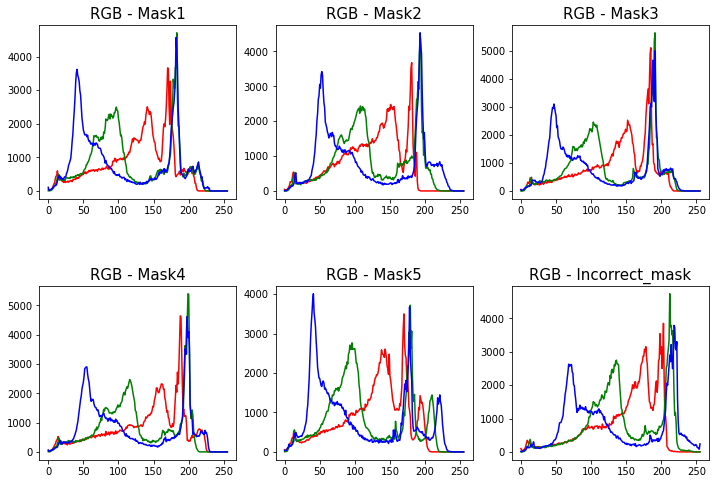

In [34]:


mask_names = ['mask1', 'mask2', 'mask3', 'mask4', 'mask5', 'incorrect_mask']
idx = 500
img_id = n_df.iloc[idx].img_id
ext = get_ext(cfg.img_dir, img_id)

# Create a figure with multiple subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

# Loop through each mask name and plot its RGB histogram on a separate subplot
for i, mask_name in enumerate(mask_names):
    row_index = i // 3
    col_index = i % 3
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, mask_name+ext)))
    colormap = ['red', 'green', 'blue']
    for j in range(3):
        histogram, bin_edges = np.histogram(img[..., j], bins=256, range=(0, 255))
        sns.lineplot(data=histogram, color=colormap[j], ax=axs[row_index, col_index])
    axs[row_index, col_index].set_title('RGB - ' + mask_name.capitalize(), fontsize=15)

# Adjust the spacing between subplots and show the plot
plt.subplots_adjust(hspace=0.5)
plt.show()

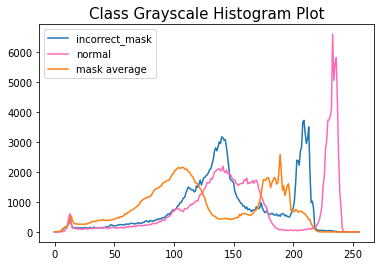

In [35]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color='hotpink')

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, num2class[i]+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0))

plt.legend(['incorrect_mask', 'normal', 'mask average'])
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

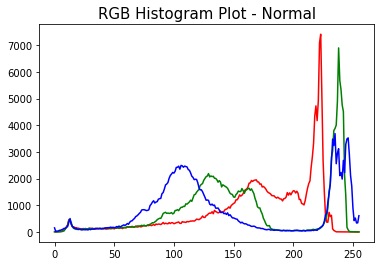

In [36]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)))

colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.title('RGB Histogram Plot - Normal', fontsize=15)
plt.show()


## 결론 

###  1. `Mask` class가 다른 `Incorrect`, `Not waer`보다 5배 정도 많다 - 불균형적이다 
###  2. `60>=` label 다른 Age label보다 약 8배 적다 - 불균형
###  3. `Female` 데이터가 `Male`보다 약 600백개 더 많다
###  4. 같은 인물로 된 데이터가 중복되서 존재하기 때문에 `train/val split`할때 고려하면 좋을 것 같다


In [37]:
n_df

,img_id,path,age,gender,mask_label,gender_label,age_label,total_label
0,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1,4
1,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1,4
2,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1,4
3,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,1,1,1,10
4,000001_female_Asian_45,../input/data/train/images/000001_female_Asian...,45,female,0,1,1,4
...,...,...,...,...,...,...,...,...
18895,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0,0
18896,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,1,0,0,6
18897,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0,0
18898,006959_male_Asian_19,../input/data/train/images/006959_male_Asian_1...,19,male,0,0,0,0


### PCA
- 이미지 특성상 분포가 명확하기가 힘들다.

In [38]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from time import time

In [39]:
n_imgs = 50

imgs = []
for img_id in df.path.values[:n_imgs]:
    for class_id in num2class:
        img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
        imgs.append(img)
imgs = np.array(imgs)
n_samples, h, w = imgs.shape

imgs = np.reshape(imgs, (n_samples, h*w))

In [40]:
n_components = 30

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(imgs)
print(f"pca is fitted in {time() - t0:.0f}s")
print(f'Explained variation per principal component: \n{pca.explained_variance_ratio_}')

eigenfaces = pca.components_.reshape((n_components, h, w))
img_pca = pca.transform(imgs)

pca is fitted in 8s
Explained variation per principal component: 
[0.16448757 0.09740206 0.05515315 0.04549906 0.04115291 0.033833
 0.02885973 0.02219858 0.02113032 0.01950075 0.01791596 0.01543301
 0.0132424  0.01276848 0.01121531 0.01079654 0.00942875 0.00919392
 0.00844942 0.00785729 0.00765638 0.00701893 0.00676732 0.0065508
 0.00624421 0.00568719 0.00553193 0.00539045 0.00517626 0.00489585]


In [41]:
pca_df = pd.DataFrame(img_pca, columns=[str(col) for col in range(n_components)])
pca_df['class_id'] = [num2class[n % len(num2class)] for n in range(n_samples)]
pca_df['class_id'] = pca_df['class_id'].map(lambda x: x if x in ['incorrect_mask', 'normal'] else 'mask')

In [42]:
pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,class_id
0,0.675016,0.106467,-0.383725,0.248384,0.241590,-0.342489,-0.325967,-0.062965,-0.435249,0.113477,...,0.097929,-0.761521,-0.589947,-1.762039,-0.135050,0.078960,0.431876,1.041379,-1.234229,incorrect_mask
1,1.495921,0.259521,0.391188,-0.049809,0.538825,0.319242,-1.648999,-1.000270,2.383012,-0.896014,...,0.372496,-0.173954,-0.114841,0.097371,0.969901,-0.075006,-1.498624,0.120308,-0.578890,mask
2,0.737063,0.012483,-0.252228,0.074387,-0.103534,-0.601282,-0.141318,-0.016650,-0.234251,-0.081782,...,0.394009,-0.418854,-0.331350,-1.906667,-0.033297,-0.138736,-0.494385,1.308634,-0.978449,mask
3,0.303155,0.204381,-0.885198,0.206139,0.367026,-0.337430,-0.655670,-0.459887,0.049209,1.024584,...,-0.426200,-0.983089,-0.169763,-0.706046,0.560358,1.591164,0.146821,-0.448149,-0.725286,mask
4,0.456404,0.185305,-0.688493,0.313414,0.346210,-0.347819,-0.409362,-0.159193,-0.304384,0.293641,...,0.125437,-1.219238,-0.502583,-1.233188,0.571413,0.679944,0.888513,0.431372,-1.385955,mask


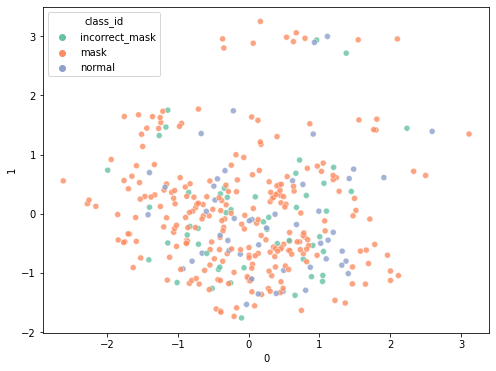

In [43]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='0', y='1',
    hue="class_id",
    data=pca_df,
    legend="full",
    palette=sns.color_palette("Set2", 3),
    alpha=0.8
)
plt.show()

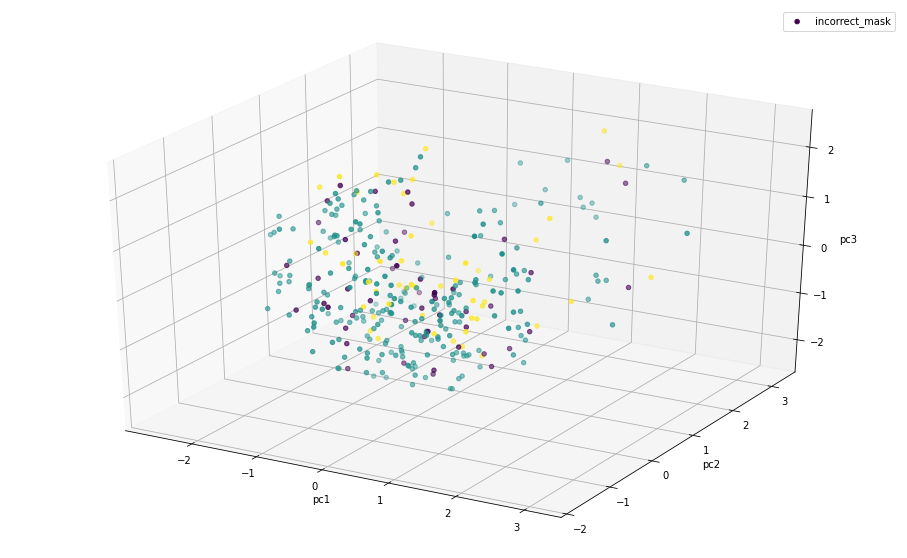

In [44]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
simplified_num2class = ['incorrect_mask', 'mask', 'normal']
simplified_class2num = {k: v for v, k in enumerate(simplified_num2class)}
ax.scatter(
    xs=pca_df["0"], 
    ys=pca_df["1"], 
    zs=pca_df["2"], 
    c=pca_df['class_id'].map(lambda x: simplified_class2num[x]), 
)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')

plt.legend(simplified_num2class)
plt.show()

In [45]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 350 samples in 0.000s...
[t-SNE] Computed neighbors for 350 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 350 / 350
[t-SNE] Mean sigma: 2.606478
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.890984
[t-SNE] KL divergence after 300 iterations: 1.004077
t-SNE done! Time elapsed: 0.587787389755249 seconds


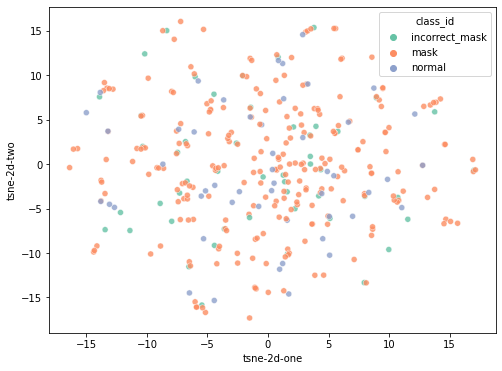

In [46]:
pca_df['tsne-2d-one'] = tsne_results[:,0]
pca_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class_id",
    palette=sns.color_palette("Set2", 3),
    data=pca_df,
    legend="full",
    alpha=0.8
)
plt.show()